# Reddit’s Invisible Brain: The Web Hidden Beneath the Threads
### *Mapping the Emotional and Cognitive Architecture of Online Communities*

**Project:** ADA 2025 - P2 Milestone
**Team:** Amer Lakrami, Hamza Barrada , Omar El Khyari , Omar Zakariya, Cesar Illanes

This notebook contains our initial analysis and data processing pipeline. We aim to answer our four key research questions by merging three distinct layers of data:
1.  **Semantic Layer (Content):** What do communities talk about? (Our K-Means Clusters)
2.  **Linguistic Layer (Psychology):** How do they talk? (LIWC Features)
3.  **Network Layer (Behavior):** Who do they talk to? (Hyperlinks & PageRank)

**Our 5-Step Analysis Pipeline:**
1.  **Data Processing:** Load raw hyperlink data and extract psychological (LIWC) features.
2.  **LIWC Analysis:** Aggregate psychological features by subreddit to create profiles.
3.  **Network Analysis:** Build the graph, find communities, and calculate centrality.
4.  **Embedding Processing:** Load subreddit embeddings and analyze semantic (topic) space.
5.  **Topic Clustering:** Run K-Means clustering to assign a*Topic Cluster ID to each community.
6.  **Integration:** Merge all three data layers into a final, analysis-ready dataset.

## Imports and Path Setup:

In [1]:
import pandas as pd
import numpy as np
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import IFrame, HTML, display 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

try:
    from src.data_processing import HyperlinkDataProcessor
    from src.embedding_processing import process_embeddings
    from src.liwc_analysis import LIWCAnalyzer
    from src.network_analysis import NetworkAnalyzer
    from src.integration import DataIntegrator
    from src.visualize_pipeline import (
            load_hyperlinks_data,
            plot_sentiment_distribution,
            plot_sentiment_volume_over_time,
            plot_top_sources_sentiment,
            plot_top_targets_sentiment,
            plot_liwc_diverging_lollipop,
            plot_attack_pattern_small_multiples,
            load_pca_variance_data,
            load_embeddings_data,
            plot_pca_variance,
            load_liwc_sentiment_comparison,
            load_subreddit_roles,
            load_psychological_profiles,
            plot_role_quadrant_map,
            plot_psychological_asymmetry,
            load_network_metrics,
            load_network_communities,
            plot_centrality_grid,
            load_topic_clusters,
            plot_topic_cluster_distribution,
            load_final_dataset,
            load_cluster_labels,
            plot_topic_network_role,
            plot_semantic_structural_heatmap,
            plot_top_influential,
            plot_top_supported,
            plot_liwc_role_lift,
            plot_liwc_radar_profiles
    )
    from src.topic_clustering import run_topic_clustering
    print("Successfully imported all pipeline classes from 'src' directory.")
except ImportError as e:
    print(f"Details: {e}")

BASE_DIR = Path('.')
DATA_DIR = BASE_DIR / 'data'
PROCESSED_DIR = DATA_DIR / 'processed'
RESULTS_DIR = BASE_DIR / 'results'
FIGURES_DIR = RESULTS_DIR / 'figures'
HTML_DIR = RESULTS_DIR / 'html'

BODY_LINKS_PATH = DATA_DIR / 'hyperlink_network' / 'soc-redditHyperlinks-body.tsv'
TITLE_LINKS_PATH = DATA_DIR / 'hyperlink_network' / 'soc-redditHyperlinks-title.tsv'
EMBEDDINGS_PATH = DATA_DIR / 'subreddit_embeddings' / 'web-redditEmbeddings-subreddits.csv'

PROCESSED_DIR.mkdir(exist_ok=True)
RESULTS_DIR.mkdir(exist_ok=True)
FIGURES_DIR.mkdir(exist_ok=True)

Successfully imported all pipeline classes from 'src' directory.


---
## Analysis Pipeline

### Step 1: Data Processing (Hyperlink & LIWC Extraction)

**Goal:** Load the raw hyperlink data, combine the `body` and `title` files, and parse the `PROPERTIES` string.

This first step, reads the 858,490 hyperlink entries and parse the `PROPERTIES` vector into 86 distinct features:
* **21 Text Properties** (word count, readability, VADER sentiment, etc.)
* **65 LIWC Features** (psychological linguistics like `LIWC_Anger`, `LIWC_We`, `LIWC_Cognitive`, etc.)

This gives us our base dataset of *individual links* and their associated psychological/textual properties.

In [2]:
# Process Hyperlinks
print("Initializing HyperlinkDataProcessor...")
processor_hp = HyperlinkDataProcessor(
    body_path=BODY_LINKS_PATH, 
    title_path=TITLE_LINKS_PATH,
    output_dir=PROCESSED_DIR
)

# Run the processing pipeline
hyperlinks_df, liwc_columns = processor_hp.run()

# Results
print("\n--- Step 1 Output ---")
print(f"Total LIWC columns extracted: {len(liwc_columns)}")
print("DataFrame Info:")
hyperlinks_df.info()

print("\nSample of processed hyperlink data (first 5 rows):")
display(hyperlinks_df.head())

Initializing HyperlinkDataProcessor...
Data Preprocessing....
LOADING HYPERLINK DATA

 Loading files...
Body links:   286,561 rows
Title links:  571,927 rows
Combined:  858,488 rows

Extracting features from PROPERTIES...
Extracted 21 text properties
Extracted 65 LIWC features
DATA CLEANING
 Standardized subreddit names (lowercase, trimmed)
Created binary sentiment indicators
Parsed timestamp into datetime, year, month, date

 Final dataset: 858,488 rows × 105 columns
DATA VALIDATION
All required columns present
No nulls in critical columns

Sentiment distribution (LINK_SENTIMENT):
 -1:   82,210 (  9.6%)
  1:  776,278 ( 90.4%)

Network composition:
Unique subreddits:    67,180
As sources:           55,863
As targets:           34,572
Unique links:        858,488

 Time range:
From: 2013-12-31 16:20:20
To:   2017-04-30 16:58:21

 Saved to: /home/hamza/ada-2025-project-barrada/data/processed/combined_hyperlinks.csv
PREPROCESSING COMPLETE

--- Step 1 Output ---
Total LIWC columns extracte

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES,LINK_SOURCE,n_characters,n_characters_no_space,frac_alpha,frac_digits,frac_uppercase,frac_whitespace,frac_special,n_words,n_unique_words,n_long_words,avg_word_length,n_unique_stopwords,frac_stopwords,n_sentences,n_long_sentences,avg_chars_per_sentence,avg_words_per_sentence,readability_index,vader_positive,vader_negative,vader_compound,LIWC_Funct,LIWC_Pronoun,LIWC_Ppron,LIWC_I,LIWC_We,LIWC_You,LIWC_SheHe,LIWC_They,LIWC_Ipron,LIWC_Article,LIWC_Verbs,LIWC_AuxVb,LIWC_Past,LIWC_Present,LIWC_Future,LIWC_Adverbs,LIWC_Prep,LIWC_Conj,LIWC_Negate,LIWC_Quant,LIWC_Numbers,LIWC_Swear,LIWC_Social,LIWC_Family,LIWC_Friends,LIWC_Humans,LIWC_Affect,LIWC_Posemo,LIWC_Negemo,LIWC_Anx,LIWC_Anger,LIWC_Sad,LIWC_CogMech,LIWC_Insight,LIWC_Cause,LIWC_Discrep,LIWC_Tentat,LIWC_Certain,LIWC_Inhib,LIWC_Incl,LIWC_Excl,LIWC_Percept,LIWC_See,LIWC_Hear,LIWC_Feel,LIWC_Bio,LIWC_Body,LIWC_Health,LIWC_Sexual,LIWC_Ingest,LIWC_Relativ,LIWC_Motion,LIWC_Space,LIWC_Time,LIWC_Work,LIWC_Achiev,LIWC_Leisure,LIWC_Home,LIWC_Money,LIWC_Relig,LIWC_Death,LIWC_Assent,LIWC_Dissent,LIWC_Nonflu,LIWC_Filler,sentiment_numeric,is_positive,is_negative,timestamp,year,month,date,LIWC_Emotion_Total,LIWC_Negemo_Specific,LIWC_Cognitive_Total,LIWC_Social_Total,LIWC_Pronoun_Total
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08...",body,345.0,298.0,0.756522,0.017391,0.086957,0.150725,0.075362,57.0,53.0,10.0,4.789474,15.0,0.315789,1.0,1.0,345.000000,57.000000,35.577895,0.073,0.080,0.1748,0.344828,0.051724,0.034483,0.000000,0.034483,0.000000,0.000000,0.0,0.017241,0.051724,0.103448,0.051724,0.000000,0.103448,0.000000,0.034483,0.034483,0.068966,0.017241,0.034483,0.000000,0.0,0.103448,0.000000,0.0,0.000000,0.051724,0.017241,0.034483,0.000000,0.000000,0.017241,0.189655,0.034483,0.0,0.034483,0.034483,0.000000,0.000000,0.068966,0.051724,0.034483,0.034483,0.000000,0.0,0.017241,0.017241,0.0,0.0,0.0,0.068966,0.017241,0.051724,0.000000,0.051724,0.068966,0.034483,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1,1,0,2013-12-31 16:39:58,2013,12,2013-12-31,0.034483,0.005747,0.048851,0.025862,0.008621
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049...",body,101.0,98.0,0.742574,0.019802,0.049505,0.059406,0.178218,14.0,14.0,2.0,5.714286,1.0,0.071429,2.0,0.0,49.500000,7.000000,16.049286,0.472,0.000,0.5538,0.066667,0.066667,0.066667,0.066667,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.066667,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.133333,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.0,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.066667,0.066667,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,-1,0,1,2013-12-31 18:18:37,2013,12,2013-12-31,0.000000,0.000000,0.022222,0.033333,0.016667
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082...",body,85.0,85.0,0.752941,0.023529,0.082353,0.011765,0.211765,10.0,10.0,2.0,7.200000,0.0,0.000000,1.0,0.0,85.000000,10.000000,23.605000,0.000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.090909,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.090909,0.090909,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1,1,0,2014-01-01 14:54:35,2014,1,2014-01-01,0.000000,0.000000,0.000000,0.022727,0.000000
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,

In [ ]:
hyperlinks_df = load_hyperlinks_data()

if hyperlinks_df is not None:
    
    print("\n Generating Static PNGs (will display below)")
    plot_sentiment_distribution(hyperlinks_df)
    plot_sentiment_volume_over_time(hyperlinks_df)
    plot_top_sources_sentiment(hyperlinks_df)
    plot_liwc_radar_profiles(
        hyperlinks_df, 
        sub_a="askreddit", 
        label_a="Positive", 
        sub_b="subredditdrama", 
        label_b="Negative", 
        save_name="step1_liwc_radar_case_study_td_vs_aww.png"
)
    plot_top_targets_sentiment(hyperlinks_df)
    plot_liwc_diverging_lollipop(hyperlinks_df)
    plot_attack_pattern_small_multiples(hyperlinks_df)
    
            
    print("STEP 1 VISUALIZATION COMPLETE")
    print(f"PNGs saved to: {FIGURES_DIR}")
else:
    print("Stopping visualization pipeline as data could not be loaded.")

### Step 2: Psychological (LIWC) Analysis

**Goal:** Aggregate the 65 LIWC features for *every link* to create psychological profiles for *every subreddit*.

This is the core of our "psychological" layer, handled by `LIWCAnalyzer`. It takes the `combined_hyperlinks.csv` (from Step 1) and calculates average psychological scores for each subreddit, based on the language they use in their outgoing links.

It answers questions like:
* "What is the average 'Anger' score for all links coming from `r/subredditdrama`?"
* "What is the average 'We' (group identity) score for links coming from `r/politics`?"

It will generate several new files in `data/processed/`, including:
* `subreddit_features_source.csv`: The average psychological profile for each subreddit's *outgoing* posts.
* `subreddit_features_target.csv`: The average psychological profile for *incoming* posts targeting a subreddit.
* `subreddit_roles.csv`: A classification of subreddits into roles like "Critic," "Target," etc.

In [ ]:
print("Initializing LIWCAnalyzer...")
analyzer_liwc = LIWCAnalyzer(
    hyperlinks_df=hyperlinks_df,
    liwc_columns=liwc_columns,
    output_dir=PROCESSED_DIR
)

liwc_results = analyzer_liwc.save_results()

print("\n--- Step 2 Output ---")
print("Successfully generated and saved all LIWC analysis files.")

print("Sample of 'Source Features' (psychology of outgoing links):")
display(liwc_results['source_features'].head())

print("\nSample of 'Target Features' (psychology of incoming links):")
display(liwc_results['target_features'].head())

print("\nTop 15 most discriminating LIWC features (Positive vs Negative Links):")
display(liwc_results['sentiment_comparison'].sort_values('abs_difference', ascending=False).head(15)[
    ['feature', 'positive_mean', 'negative_mean', 'difference']
])


Initializing LIWCAnalyzer...
SAVING RESULTS
\Saving source subreddit features...
AGGREGATING LIWC BY SOURCE SUBREDDIT

 Computing basic statistics...
 Aggregating 65 LIWC features...

 Aggregated 55,863 subreddits
 Features per subreddit: 79
Saving target subreddit features...
AGGREGATING LIWC BY TARGET SUBREDDIT

 Computing basic statistics...
 Aggregating 65 LIWC features...

 Aggregated 34,572 subreddits
 Features per subreddit: 79
Saving sentiment comparison...
COMPARING POSITIVE VS NEGATIVE LINKS

 Sample sizes:
    Positive links:    776,278
    Negative links:     82,210

 Computing differences across 65 features...

Top 15 most discriminating features:
  LIWC_Funct           Pos:   0.30  Neg:   0.35  ↑ Δ:   0.06
  LIWC_Negemo          Pos:   0.01  Neg:   0.06  ↑ Δ:   0.05
  LIWC_Affect          Pos:   0.04  Neg:   0.09  ↑ Δ:   0.05
  LIWC_Anger           Pos:   0.01  Neg:   0.04  ↑ Δ:   0.04
  LIWC_Social          Pos:   0.06  Neg:   0.08  ↑ Δ:   0.02
  LIWC_Verbs           Pos

,subreddit,n_links,avg_sentiment,n_positive_links,n_negative_links,n_unique_targets,LIWC_Funct_mean,LIWC_Pronoun_mean,LIWC_Ppron_mean,LIWC_I_mean,LIWC_We_mean,LIWC_You_mean,LIWC_SheHe_mean,LIWC_They_mean,LIWC_Ipron_mean,LIWC_Article_mean,LIWC_Verbs_mean,LIWC_AuxVb_mean,LIWC_Past_mean,LIWC_Present_mean,LIWC_Future_mean,LIWC_Adverbs_mean,LIWC_Prep_mean,LIWC_Conj_mean,LIWC_Negate_mean,LIWC_Quant_mean,LIWC_Numbers_mean,LIWC_Swear_mean,LIWC_Social_mean,LIWC_Family_mean,LIWC_Friends_mean,LIWC_Humans_mean,LIWC_Affect_mean,LIWC_Posemo_mean,LIWC_Negemo_mean,LIWC_Anx_mean,LIWC_Anger_mean,LIWC_Sad_mean,LIWC_CogMech_mean,LIWC_Insight_mean,LIWC_Cause_mean,LIWC_Discrep_mean,LIWC_Tentat_mean,LIWC_Certain_mean,LIWC_Inhib_mean,LIWC_Incl_mean,LIWC_Excl_mean,LIWC_Percept_mean,LIWC_See_mean,LIWC_Hear_mean,LIWC_Feel_mean,LIWC_Bio_mean,LIWC_Body_mean,LIWC_Health_mean,LIWC_Sexual_mean,LIWC_Ingest_mean,LIWC_Relativ_mean,LIWC_Motion_mean,LIWC_Space_mean,LIWC_Time_mean,LIWC_Work_mean,LIWC_Achiev_mean,LIWC_Leisure_mean,LIWC_Home_mean,LIWC_Money_mean,LIWC_Relig_mean,LIWC_Death_mean,LIWC_Assent_mean,LIWC_Dissent_mean,LIWC_Nonflu_mean,LIWC_Filler_mean,negativity_ratio,positivity_ratio,sentiment_balance,Emotion_score,Social_score,Cognitive_score,Pronouns_score,Drives_score
0,007,1,1.0,1,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,07scape,2,1.0,2,0,1,0.385185,0.062834,0.030292,0.002466,0.005096,0.008981,0.001419,0.012866,0.032542,0.054256,0.146542,0.101921,0.010421,0.070471,0.013957,0.032847,0.080685,0.033753,0.009679,0.017144,0.004605,0.0,0.04581,0.0,0.0,0.002117,0.030358,0.019566,0.010793,0.000698,0.005118,0.004976,0.111689,0.012702,0.02559,0.016489,0.02536,0.008839,0.003885,0.021148,0.019173,0.015964,0.009286,0.004212,0.002466,0.00826,0.004561,0.000349,0.0,0.00335,0.118115,0.011283,0.040833,0.067930,0.009396,0.015889,0.007071,0.006024,0.005794,0.002652,0.001419,0.001582,0.003885,0.0,0.002281,0.0,1.0,1.0,0.011918,0.011982,0.033445,0.007352,0.006892
2,07thexpansion,1,1.0,1,0,1,0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.095238,0.047619,0.047619,0.000000,0.047619,0.000000,0.000000,0.095238,0.000000,0.047619,0.047619,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.00000,0.142857,0.000000,0.095238,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.0,0.000000,0.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,098f6bcd4621d373,1,1.0,1,0,1,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.00000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,1.0,0.000000,0.000000,0.033333,0.000000,0.000000
4,0________0,1,1.0,1,0,1,0.400000,0.100000,0.100000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.100000,0.100000,0.100000,0.000000,0.000000,0.000000,0.100000,0.000000,0.0


Sample of 'Target Features' (psychology of incoming links):


,subreddit,n_links,avg_sentiment,n_positive_links,n_negative_links,n_unique_sources,LIWC_Funct_mean,LIWC_Pronoun_mean,LIWC_Ppron_mean,LIWC_I_mean,LIWC_We_mean,LIWC_You_mean,LIWC_SheHe_mean,LIWC_They_mean,LIWC_Ipron_mean,LIWC_Article_mean,LIWC_Verbs_mean,LIWC_AuxVb_mean,LIWC_Past_mean,LIWC_Present_mean,LIWC_Future_mean,LIWC_Adverbs_mean,LIWC_Prep_mean,LIWC_Conj_mean,LIWC_Negate_mean,LIWC_Quant_mean,LIWC_Numbers_mean,LIWC_Swear_mean,LIWC_Social_mean,LIWC_Family_mean,LIWC_Friends_mean,LIWC_Humans_mean,LIWC_Affect_mean,LIWC_Posemo_mean,LIWC_Negemo_mean,LIWC_Anx_mean,LIWC_Anger_mean,LIWC_Sad_mean,LIWC_CogMech_mean,LIWC_Insight_mean,LIWC_Cause_mean,LIWC_Discrep_mean,LIWC_Tentat_mean,LIWC_Certain_mean,LIWC_Inhib_mean,LIWC_Incl_mean,LIWC_Excl_mean,LIWC_Percept_mean,LIWC_See_mean,LIWC_Hear_mean,LIWC_Feel_mean,LIWC_Bio_mean,LIWC_Body_mean,LIWC_Health_mean,LIWC_Sexual_mean,LIWC_Ingest_mean,LIWC_Relativ_mean,LIWC_Motion_mean,LIWC_Space_mean,LIWC_Time_mean,LIWC_Work_mean,LIWC_Achiev_mean,LIWC_Leisure_mean,LIWC_Home_mean,LIWC_Money_mean,LIWC_Relig_mean,LIWC_Death_mean,LIWC_Assent_mean,LIWC_Dissent_mean,LIWC_Nonflu_mean,LIWC_Filler_mean,negativity_ratio,positivity_ratio,sentiment_balance,Emotion_score,Social_score,Cognitive_score,Pronouns_score,Drives_score
0,01001111010100000,1,1.0,1,0,1,0.315301,0.047913,0.027821,0.007728,0.012365,0.004637,0.003091,0.003091,0.020093,0.064915,0.064915,0.046368,0.001546,0.027821,0.027821,0.007728,0.089645,0.035549,0.004637,0.017002,0.010819,0.001546,0.068006,0.004637,0.000000,0.007728,0.043277,0.024730,0.018547,0.001546,0.015456,0.000000,0.080371,0.012365,0.009274,0.003091,0.012365,0.006182,0.004637,0.026275,0.007728,0.003091,0.000000,0.000000,0.003091,0.010819,0.007728,0.001546,0.001546,0.000000,0.092736,0.012365,0.034003,0.037094,0.010819,0.013910,0.007728,0.003091,0.010819,0.001546,0.007728,0.000000,0.001546,0.0,0.001546,0.0,1.0,1.0,0.017259,0.020093,0.020608,0.006955,0.007949
1,0131,1,1.0,1,0,1,0.465649,0.114504,0.038168,0.022901,0.000000,0.000000,0.007634,0.015267,0.076336,0.061069,0.145038,0.099237,0.007634,0.106870,0.007634,0.045802,0.083969,0.045802,0.022901,0.030534,0.015267,0.000000,0.053435,0.000000,0.000000,0.007634,0.053435,0.053435,0.000000,0.000000,0.000000,0.000000,0.145038,0.061069,0.015267,0.007634,0.000000,0.022901,0.007634,0.007634,0.030534,0.000000,0.000000,0.000000,0.000000,0.007634,0.007634,0.000000,0.000000,0.000000,0.129771,0.068702,0.022901,0.038168,0.015267,0.015267,0.007634,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,1.0,0.017812,0.015267,0.041985,0.009542,0.005453
2,07scape,3,1.0,3,0,1,0.468709,0.093015,0.050420,0.026426,0.002991,0.016359,0.000669,0.004309,0.042594,0.065733,0.099667,0.052300,0.020943,0.066715,0.002991,0.049480,0.122157,0.062867,0.017072,0.027196,0.003995,0.000983,0.063951,0.000000,0.001004,0.004644,0.049978,0.028618,0.020377,0.000983,0.011360,0.001967,0.154896,0.020879,0.024143,0.016088,0.033974,0.008577,0.002008,0.035668,0.030712,0.017553,0.010314,0.002301,0.002971,0.012950,0.011632,0.000983,0.000000,0.000335,0.127493,0.019541,0.065211,0.037992,0.019016,0.020272,0.012552,0.000335,0.017803,0.001339,0.002008,0.001987,0.009833,0.0,0.000983,0.0,1.0,1.0,0.018880,0.017400,0.043093,0.012521,0.010475
3,093game,1,1.0,1,0,1,0.260870,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.043478,0.043478,0.000000,0.043478,0.000000,0.000000,0.173913,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.086957,0.000000,0.043478,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,1.0,0.000000,0.010870,0.014493,0.000000,0.006211
4,0b0t,1,1.0,1,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


Top 15 most discriminating LIWC features (Positive vs Negative Links):


,feature,positive_mean,negative_mean,difference
0,LIWC_Funct,0.295647,0.352010,0.056363
28,LIWC_Negemo,0.011705,0.062464,0.050759
26,LIWC_Affect,0.038172,0.085882,0.047710
30,LIWC_Anger,0.005176,0.042650,0.037474
22,LIWC_Social,0.061566,0.081984,0.020418
10,LIWC_Verbs,0.066732,0.084556,0.017824
32,LIWC_CogMech,0.095646,0.112553,0.016907
45,LIWC_Bio,0.017195,0.033414,0.016220
13,LIWC_Present,0.042945,0.058868,0.015923
21,LIWC_Swear,0.001614,0.016292,0.014679


Loading LIWC Analysis Data ---
Generating step2_anger_asymmetry.png...


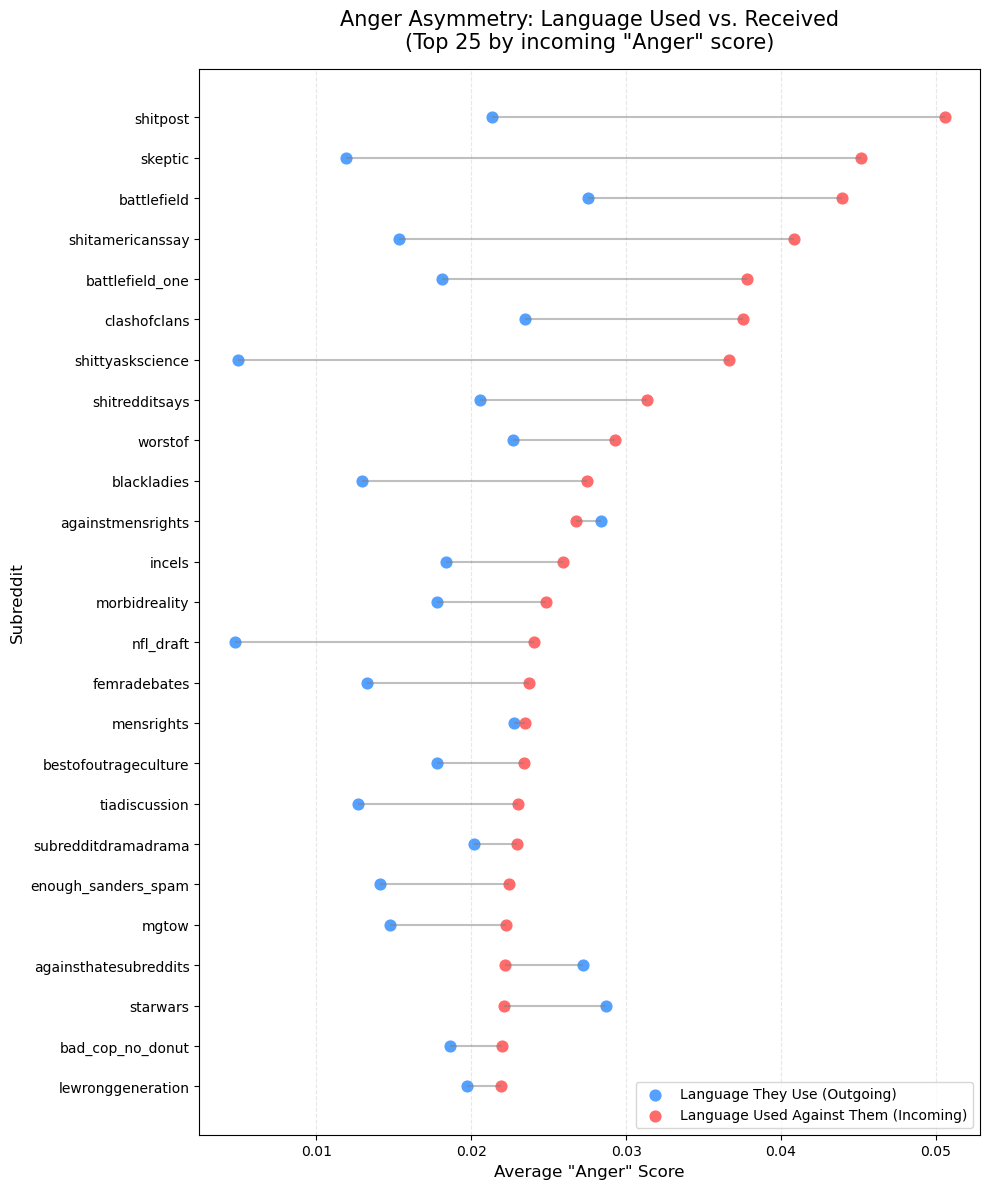

Saved PNG: /home/hamza/barrADA/ada-2025-project-barrada/results/figures/step2_anger_asymmetry.png
Generating step2_role_quadrant.png...


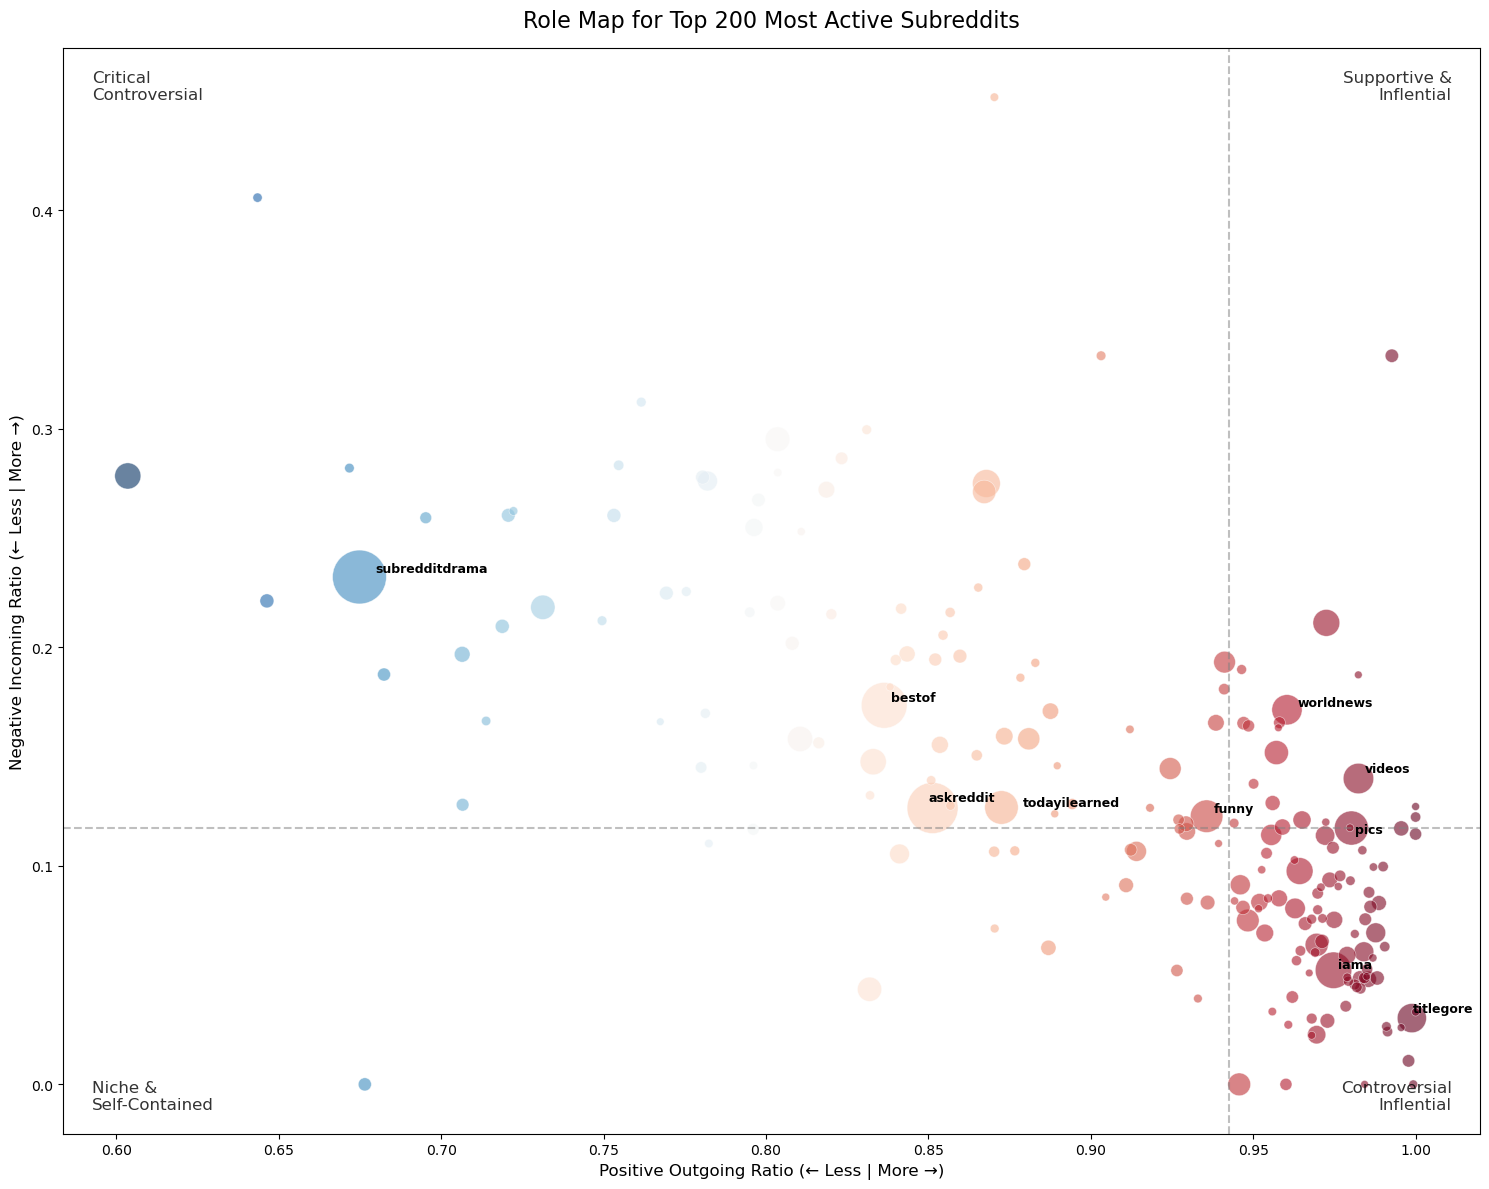

Saved PNG: /home/hamza/barrADA/ada-2025-project-barrada/results/figures/step2_role_quadrant.png
Generating step2_top_influential.png...


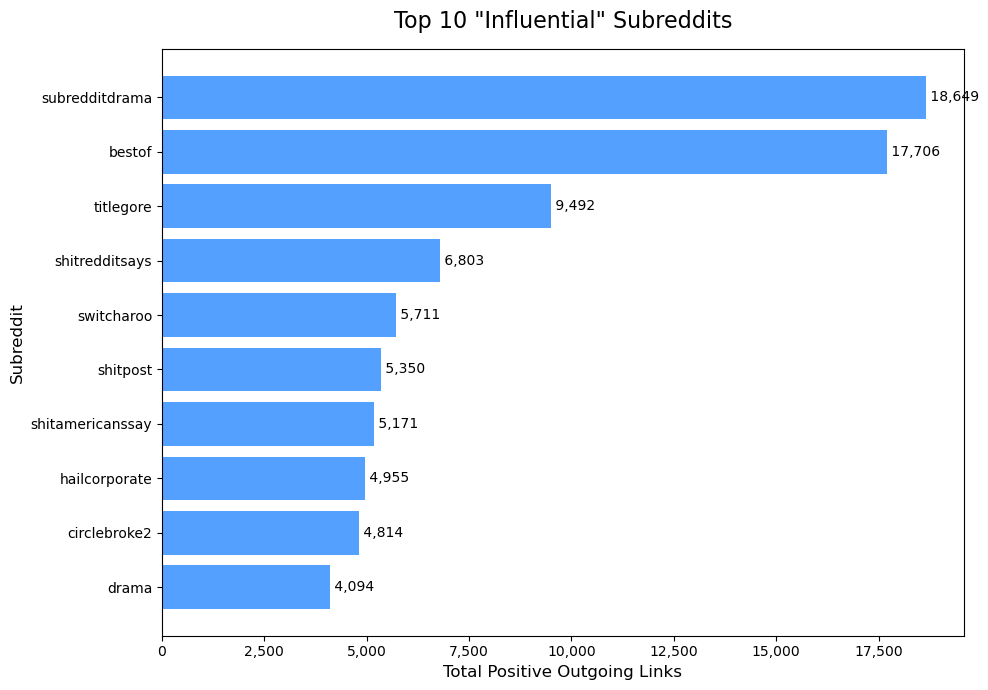

Saved PNG: /home/hamza/barrADA/ada-2025-project-barrada/results/figures/step2_top_influential.png
Generating step2_top_supported.png...


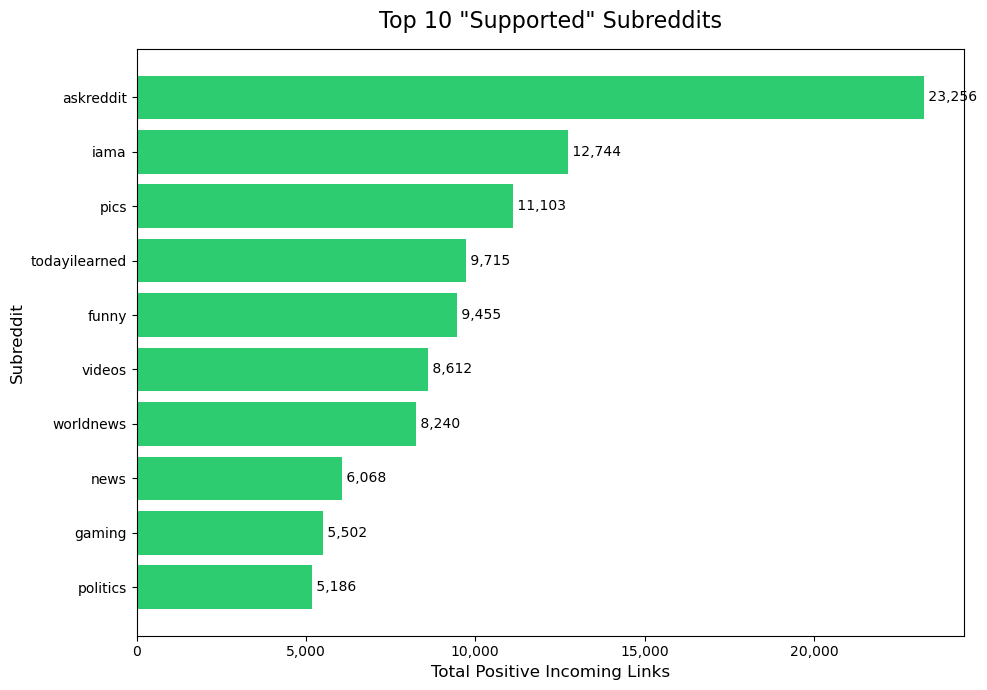

Saved PNG: /home/hamza/barrADA/ada-2025-project-barrada/results/figures/step2_top_supported.png

STEP 2 LIWC VISUALIZATION COMPLETE
PNGs saved to: results/figures


In [ ]:
print("Loading LIWC Analysis Data ---")
df_sent_comp = load_liwc_sentiment_comparison()
df_roles = load_subreddit_roles()
df_profiles = load_psychological_profiles()


if df_roles is not None:
    plot_psychological_asymmetry(df_roles)
else:
    print("Skipping Role Map and Asymmetry plots: 'subreddit_roles.csv' not found.")
    
if df_roles is not None:
    plot_role_quadrant_map(df_roles)
    plot_top_influential(df_roles)
    plot_top_supported(df_roles)
else:
    print("Skipping Heatmap plot: 'psychological_profiles.csv' not found.")

print("\nSTEP 2 LIWC VISUALIZATION COMPLETE")
print(f"PNGs saved to: {FIGURES_DIR}")

### Step 3: Network Structure Analysis

**Goal:** Build the actual graph of Reddit communities to understand the structural properties of the ecosystem.

This step, handled by `NetworkAnalyzer`, takes our `combined_hyperlinks.csv` (from Step 1) and constructs a `networkx` graph. It then performs several critical network science analyses:

1.  **Build Graphs:** Creates a main directed graph, plus separate graphs for only positive and only negative links.
2.  **Node Metrics:** Calculates centrality scores for every subreddit (PageRank, Betweenness, Hubs & Authorities).
3.  **Community Detection:** Uses the Louvain algorithm to find clusters of subreddits that are densely connected to each other, regardless of their topic.

This gives us our "Structural" features (`network_node_metrics.csv` and `network_communities.csv`).

In [ ]:
print("Initializing NetworkAnalyzer...")
analyzer_network = NetworkAnalyzer(
    hyperlinks_df=hyperlinks_df,
    output_dir=PROCESSED_DIR
)

# Build the networks first
analyzer_network.build_networks()

network_results = analyzer_network.save_results()

# --- Show Results ---
print("\n--- Step 3 Output ---")
print("Successfully generated and saved all Network analysis files.")

print("\nBasic Network Stats:")
display(network_results['stats'])

print("\nSample of 'Node Metrics' (PageRank, Centrality, etc.):")
display(network_results['metrics'].sort_values('pagerank', ascending=False).head())

print("\nTop 5 Largest Communities found by Louvain:")
display(network_results['communities']['community'].value_counts().head(5))

Initializing NetworkAnalyzer...

 Building main directed network...
 Nodes:     67,180
 Edges:    339,643

 Building positive-only network...
Nodes:     65,892
Edges:    321,539

 Building negative-only network...
Nodes:     12,069
Edges:     41,170
\ Building undirected network for community detection...
SAVING NETWORK RESULTS

 Saving basic statistics...
BASIC NETWORK STATISTICS

 Network Overview:
    Nodes:                  67,180
    Edges:                 339,643
    Density:              0.000075
    Reciprocity:             0.177

  Weakly connected:          712
    Strongly connected:     45,564
    Largest component:      65,648 ( 97.7%)

 Degree Statistics:
    In-degree  - Mean:     5.06, Median:      1, Max:   5448
    Out-degree - Mean:     5.06, Median:      1, Max:   3111
 Saving node metrics...
COMPUTING NODE METRICS

 Computing metrics for 67,180 nodes...
Degree centrality...
PageRank...
HITS (hubs and authorities)...
Betweenness centrality...
Sampling 50 nodes for b

{'n_nodes': 67180,
 'n_edges': 339643,
 'density': 7.525738678606207e-05,
 'n_weakly_connected_components': 712,
 'n_strongly_connected_components': 45564,
 'largest_component_size': 65648,
 'largest_component_fraction': 0.9771955939267639,
 'reciprocity': 0.1765147522545732}


Sample of 'Node Metrics' (PageRank, Centrality, etc.):


,subreddit,in_degree,out_degree,total_degree,in_weight,out_weight,total_weight,in_degree_centrality,out_degree_centrality,pagerank,hub_score,authority_score,betweenness,clustering,avg_in_sentiment,avg_out_sentiment,n_positive_in,n_negative_in,n_positive_out,n_negative_out,neg_in_ratio,neg_out_ratio
7,askreddit,5448,363,5811,26622,1338,27960,0.081097,0.005403,0.022047,0.003534,0.022474,0.026487,0.007450,0.818591,0.765507,23256,3366,1139,199,0.126437,0.148729
25,iama,4508,387,4895,13446,1187,14633,0.067104,0.005761,0.017709,0.001468,0.008558,0.017901,0.009267,0.923402,0.961794,12744,702,1157,30,0.052209,0.025274
26,pics,3335,169,3504,12578,253,12831,0.049643,0.002516,0.011252,0.000278,0.018867,0.006055,0.014273,0.853036,0.975345,11103,1475,248,5,0.117268,0.019763
259,funny,3031,472,3503,10777,979,11756,0.045118,0.007026,0.010050,0.002102,0.016711,0.012485,0.015727,0.816140,0.860227,9455,1322,916,63,0.122669,0.064351
90,videos,2644,242,2886,10013,341,10354,0.039358,0.003602,0.009317,0.000318,0.016987,0.005855,0.019863,0.818067,0.975010,8612,1401,335,6,0.139918,0.017595



Top 5 Largest Communities found by Louvain:


community
3     11000
5      6990
6      6703
10     3901
30     3766
Name: count, dtype: int64

Loading Network Analysis Data
Generating step3_centrality_grid.png...


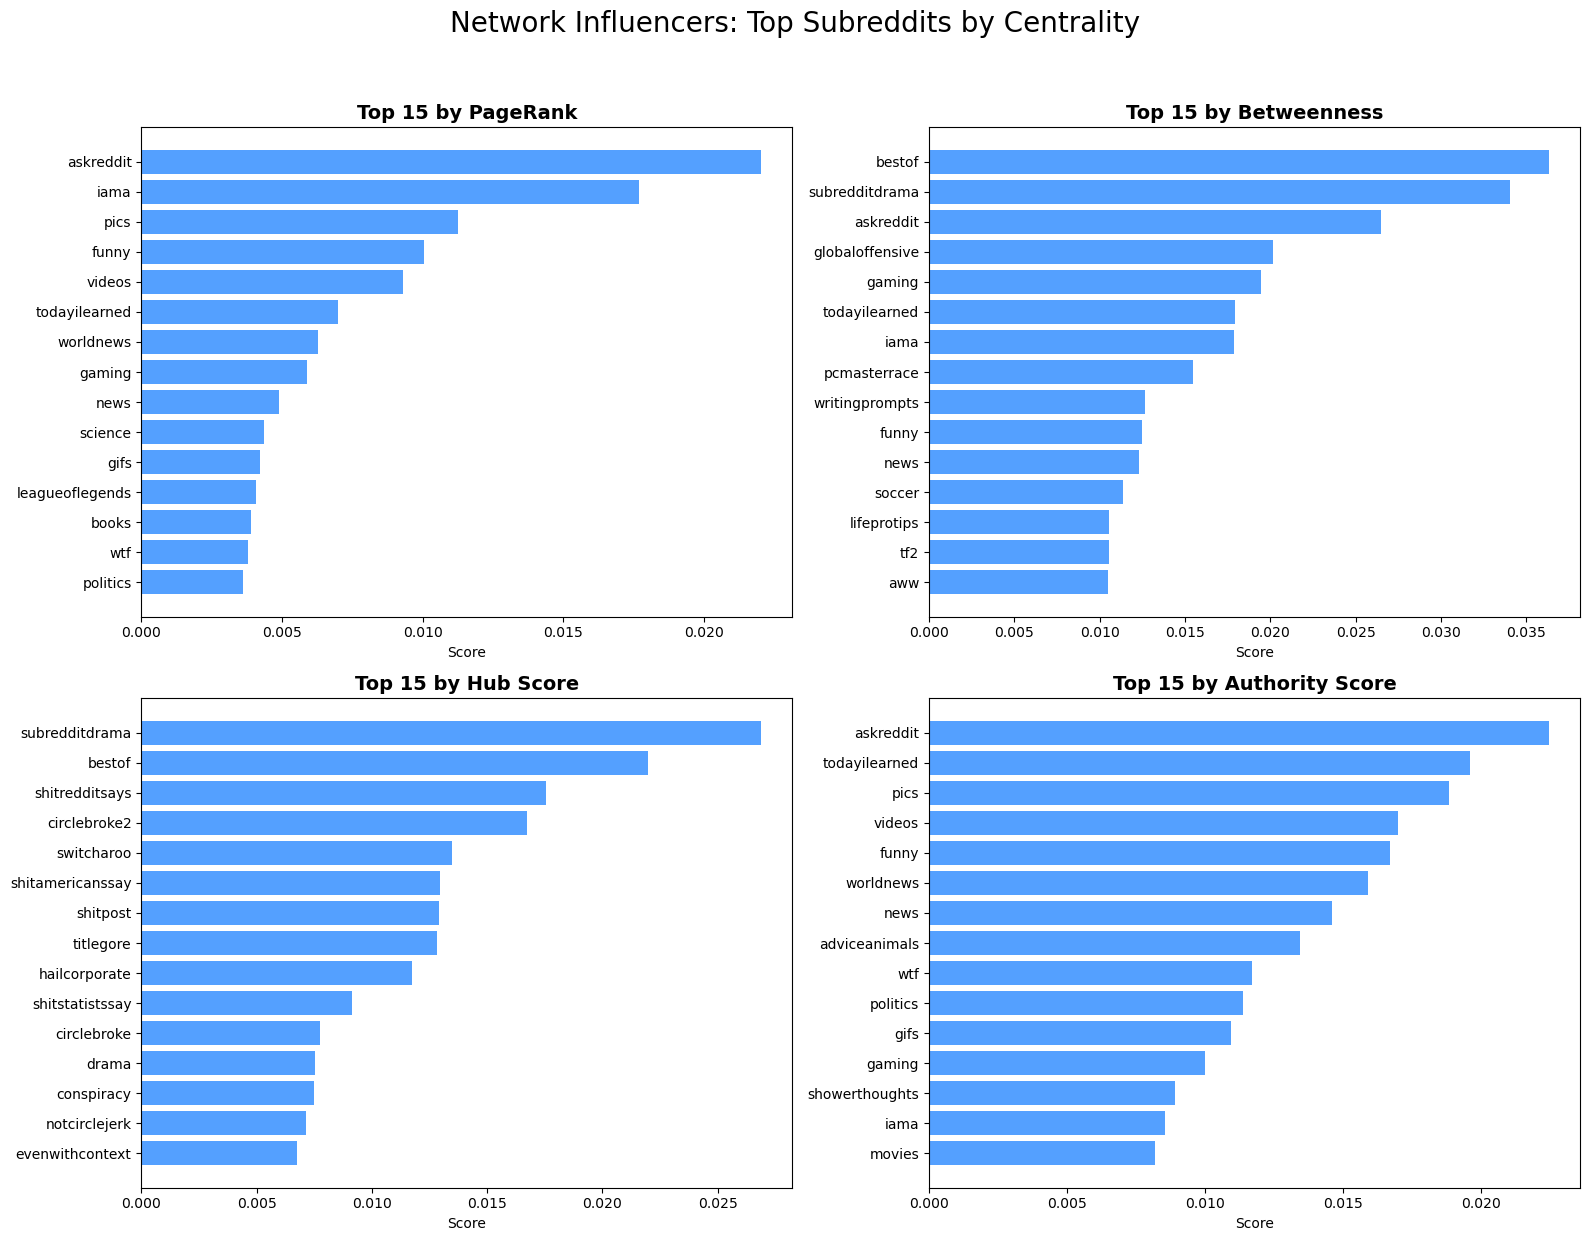

Saved PNG: /home/hamza/barrADA/ada-2025-project-barrada/results/figures/step3_centrality_grid.png

STEP 3 NETWORK VISUALIZATION COMPLETE
PNGs saved to: results/figures


In [ ]:
print("Loading Network Analysis Data")
df_metrics = load_network_metrics()
df_communities = load_network_communities()

if df_metrics is not None:
    plot_centrality_grid(df_metrics)
else:
    print("Skipping Centrality Grid: 'network_node_metrics.csv' not found.")

print("\nSTEP 3 NETWORK VISUALIZATION COMPLETE")
print(f"PNGs saved to: {FIGURES_DIR}")

### Step 4: Embedding Processing (Semantic Analysis)

**Goal:** Load the 300-dimensional subreddit embeddings (`web-redditEmbeddings-subreddits.csv`) to understand the *content* and *topic* of each community.

This step, handled by `EmbeddingProcessor`, does the essential feature engineering:
1.  **Loads & Validates** the 51k+ embedding vectors.
2.  **Runs PCA (Principal Component Analysis):** It reduces the 300 embedding dimensions down to 50, capturing the most important semantic information (e.g., `pca_0`, `pca_1`...). This creates the "Semantic" features for our final dataset.
3.  **Saves** the result to `embeddings_processed.csv`.


In [ ]:
(embeddings_df, pca_model) = process_embeddings(
    embeddings_path=EMBEDDINGS_PATH,
    output_dir=PROCESSED_DIR
)

# Show Results
print("\n--- Step 4 Output ---")
print(f"PCA model explains {np.sum(pca_model.explained_variance_ratio_)*100:.2f}% of variance with 50 components.")

print("\nSample of processed embedding data (with new PCA columns):")
display(embeddings_df.head())

Embedding Processing....
Loading.....
Raw shape: (51278, 301)
 Columns: 1 subreddit + 300 embedding dimensions
 Removed 0 duplicate subreddits

 Loaded embeddings for 51,278 subreddits
Embedding validation
 No missing values

 Embedding statistics:
    Mean:   -0.001681
    Std:    0.146797
    Min:    -5.268686
    Max:    5.467387
PCA Dimensionality Reduction....

 Computing PCA (50 components)...

 Variance explained:
All 50 components: 92.2%

 Saved processed embeddings: /home/hamza/barrADA/ada-2025-project-barrada/data/processed/embeddings_processed.csv
 Embedding Processing Complete

--- Step 4 Output ---
PCA model explains 92.19% of variance with 50 components.

Sample of processed embedding data (with new PCA columns):


,subreddit,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49,emb_50,emb_51,emb_52,emb_53,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,emb_64,emb_65,emb_66,emb_67,emb_68,emb_69,emb_70,emb_71,emb_72,emb_73,emb_74,emb_75,emb_76,emb_77,emb_78,emb_79,emb_80,emb_81,emb_82,emb_83,emb_84,emb_85,emb_86,emb_87,emb_88,emb_89,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99,emb_100,emb_101,emb_102,emb_103,emb_104,emb_105,emb_106,emb_107,emb_108,emb_109,emb_110,emb_111,emb_112,emb_113,emb_114,emb_115,emb_116,emb_117,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,emb_128,emb_129,emb_130,emb_131,emb_132,emb_133,emb_134,emb_135,emb_136,emb_137,emb_138,emb_139,emb_140,emb_141,emb_142,emb_143,emb_144,emb_145,emb_146,emb_147,emb_148,emb_149,emb_150,emb_151,emb_152,emb_153,emb_154,emb_155,emb_156,emb_157,emb_158,emb_159,emb_160,emb_161,emb_162,emb_163,emb_164,emb_165,emb_166,emb_167,emb_168,emb_169,emb_170,emb_171,emb_172,emb_173,emb_174,emb_175,emb_176,emb_177,emb_178,emb_179,emb_180,emb_181,emb_182,emb_183,emb_184,emb_185,emb_186,emb_187,emb_188,emb_189,emb_190,emb_191,emb_192,emb_193,emb_194,emb_195,emb_196,emb_197,emb_198,emb_199,emb_200,emb_201,emb_202,emb_203,emb_204,emb_205,emb_206,emb_207,emb_208,emb_209,emb_210,emb_211,emb_212,emb_213,emb_214,emb_215,emb_216,emb_217,emb_218,emb_219,emb_220,emb_221,emb_222,emb_223,emb_224,emb_225,emb_226,emb_227,emb_228,emb_229,emb_230,emb_231,emb_232,emb_233,emb_234,emb_235,emb_236,emb_237,emb_238,emb_239,emb_240,emb_241,emb_242,emb_243,emb_244,emb_245,emb_246,emb_247,emb_248,emb_249,emb_250,emb_251,emb_252,emb_253,emb_254,emb_255,emb_256,emb_257,emb_258,emb_259,emb_260,emb_261,emb_262,emb_263,emb_264,emb_265,emb_266,emb_267,emb_268,emb_269,emb_270,emb_271,emb_272,emb_273,emb_274,emb_275,emb_276,emb_277,emb_278,emb_279,emb_280,emb_281,emb_282,emb_283,emb_284,emb_285,emb_286,emb_287,emb_288,emb_289,emb_290,emb_291,emb_292,emb_293,emb_294,emb_295,emb_296,emb_297,emb_298,emb_299,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49
0,spiders,0.158972,0.285813,0.226329,-0.183338,-0.163159,-0.188910,0.422705,0.168602,0.178193,-0.149062,-0.300842,0.250692,-0.094018,-0.137390,0.481468,0.142735,0.162125,-0.457625,-0.005093,-0.273027,-0.337085,-0.217706,-0.330685,0.007393,0.169097,0.116136,0.546717,-0.038156,0.067753,0.275081,0.890474,-0.109753,0.043334,0.640792,0.673051,0.476472,-0.030415,0.066892,0.471129,-0.339831,-0.747467,-0.109928,0.416121,-0.350133,0.712881,0.171884,0.918882,-0.061754,0.548397,0.208283,0.193454,-0.528931,-0.157124,0.121313,1.057225,-0.230851,0.714269,-0.200375,0.109928,0.026177,-0.820041,-0.060443,0.745277,0.006133,-0.335152,-0.153250,-0.425811,-0.446891,-0.398313,-0.155923,0.571123,0.241867,0.012326,-0.141842,-0.452672,0.106994,-0.293534,-0.406696,0.063992,0.147539,0.050882,-0.206677,-0.009601,0.303460,0.103411,0.474364,-0.317152,-0.002853,-0.429201,0.249675,-0.084892,-0.208370,-0.997411,-0.004180,0.515307,0.270712,-0.169075,-0.073621,-0.287748,0.203007,0.037525,-0.009384,-0.251375,0.111070,0.186933,0.523963,0.552564,0.286402,0.122608,0.741214,-0.318127,0.312066,0.009872,0.008895,0.066247,0.007472,0.215160,-0.206872,0.000868,0.261308,0.081798,0.414977,0.098206,-0.616977,0.318122,-0.010342,-0.142088,-0.788810,0.513688,0.098844,-0.020168,-0.037938,-0.325909,-0.585896,-0.416931,0.106078,-0.142849,-0.036123,-0.865125,-0.197684,0.123392,0.405778,-0.21

Generating step4_pca_variance.png...
Saved PNG: /home/hamza/barrADA/ada-2025-project-barrada/results/figures/step4_pca_variance.png
STEP 4 VISUALIZATION COMPLETE
PNGs saved to: results/figures


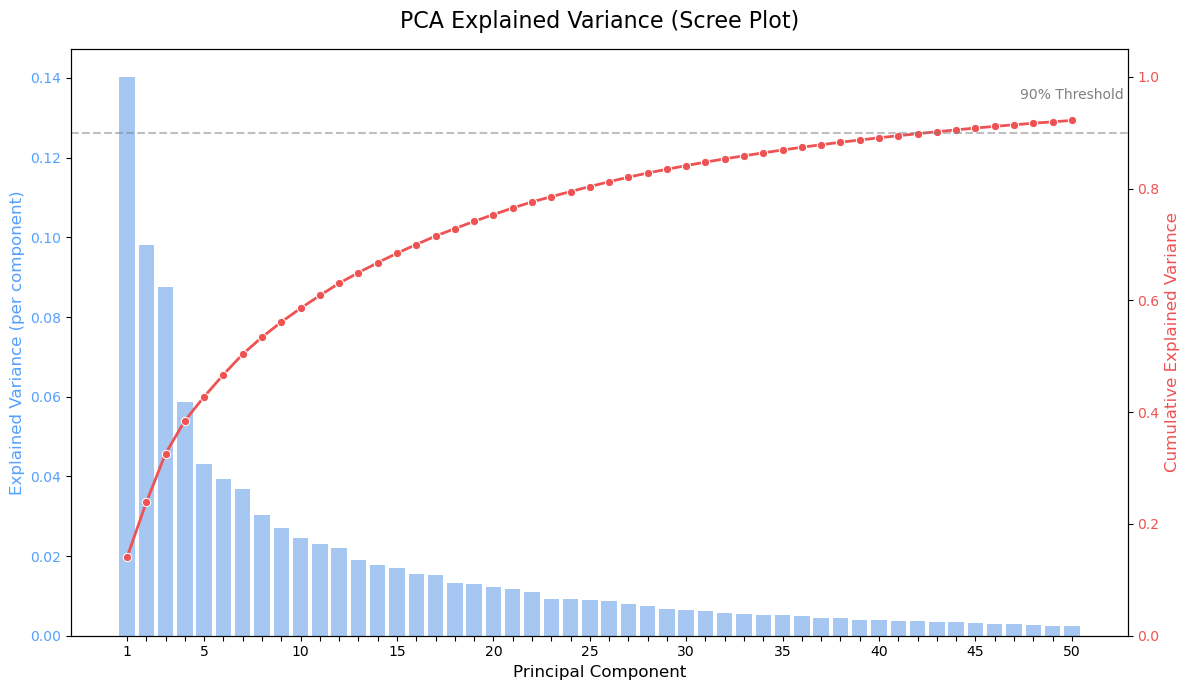

In [ ]:
pca_var_df = load_pca_variance_data()
embeddings_df = load_embeddings_data()

if pca_var_df is not None and embeddings_df is not None:
    
    plot_pca_variance(pca_var_df)
        
    print("STEP 4 VISUALIZATION COMPLETE")
    print(f"PNGs saved to: {FIGURES_DIR}")
else:
    print("Stopping visualization pipeline as Step 4 data could not be loaded.")

### Step 5 Topic Clustering (Semantic Content)

**Goal:**  
Run K-Means clustering (`K=40`) on the 300-dimensional subreddit embeddings to assign a **Topic Cluster ID** to each community.

**Output:**  
This step generates `embeddings_kmeans_topic_40.csv`, which provides the **third, distinct dimension (Content/Topic)** for our integrated analysis.

In [ ]:
# Run clustering (or reload if already saved inside the function)
df_clusters = run_topic_clustering(
    embeddings_path="data/subreddit_embeddings/web-redditEmbeddings-subreddits.csv",
    output_dir="data/processed"
)

# --- Show basic results ---
print("\n--- Step 5 Output ---")
print("Successfully generated and saved Topic Clustering results.\n")


Loading raw embeddings...
Running K-Means clustering (K=40) on 51278 subreddits...
  Clustering complete
  Silhouette (Cosine): 0.0552
  Davies-Bouldin: 2.4361

 Topic clusters saved to: data/processed/embeddings_kmeans_40.csv
 Cluster label map saved to: data/processed/cluster_labels_40.csv

Top 10 central + 10 random members per cluster:

Cluster 0 (Spam) - 1400 members
  Top 10 central:
    1. pattifierro
    2. philliphansen
    3. jessicawright
    4. bestsoles
    5. carbonknightsgaming
    6. toolsua
    7. arlenepatel
    8. lesliebutler
    9. xxxeuropornxxx
    10. lsucsrs
  10 Random:
    1. nicovideo
    2. ukrcult
    3. bombing
    4. yashiraclark
    5. jonboone
    6. ronandfez
    7. theukrainians
    8. privacyrus
    9. kidneydisease
    10. itesia

Cluster 1 (Games) - 3648 members
  Top 10 central:
    1. dontstarvetogether
    2. pixelpiracy
    3. allthemods
    4. cracksupport
    5. rs2vietnam
    6. dungeonoftheendless
    7. resonant_rise
    8. oversumo
    9

--- Loading Topic Clustering Data ---

--- Generating Static PNGs (will display below) ---
Generating step5_topic_distribution.png...


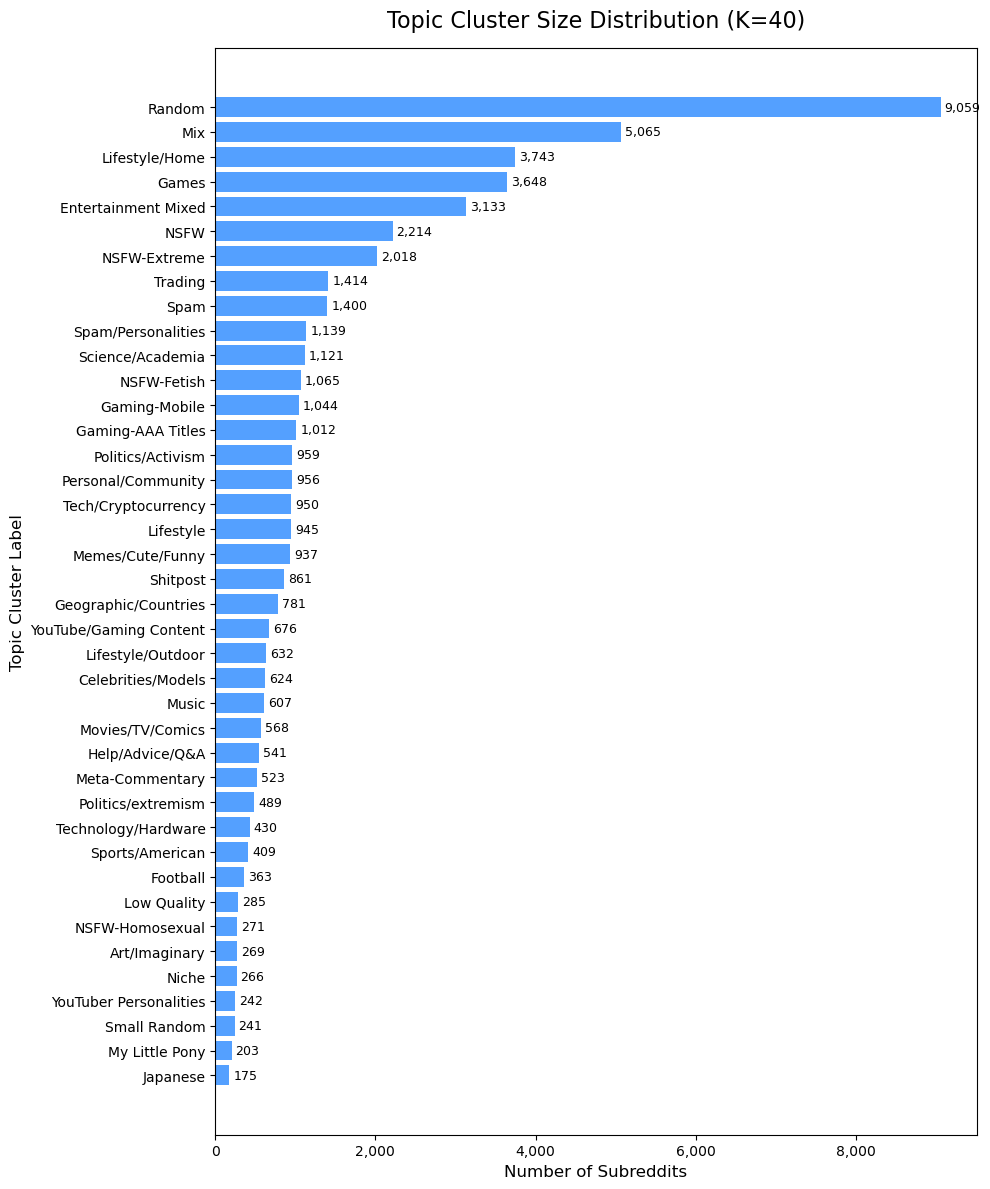

Saved PNG: /home/hamza/barrADA/ada-2025-project-barrada/results/figures/step5_topic_distribution.png

STEP 5 TOPIC CLUSTERING VISUALIZATION COMPLETE
PNGs saved to: results/figures


In [ ]:
# --- Step 5: Topic Clustering Visualizations ---
print("--- Loading Topic Clustering Data ---")
df_clusters = load_topic_clusters()

# We also need the PCA data from Step 2
df_embeddings = load_embeddings_data() 

# --- Generate Static PNGs ---
print("\n--- Generating Static PNGs (will display below) ---")

if df_clusters is not None:
    plot_topic_cluster_distribution(df_clusters)
else:
    print("Skipping Topic Distribution plot: 'embeddings_kmeans_40.csv' not found.")

print("\nSTEP 5 TOPIC CLUSTERING VISUALIZATION COMPLETE")
print(f"PNGs saved to: {FIGURES_DIR}")

### Step 6: Data Integration (The Final Merge)

**Goal:** Combine all our processed files (`network_metrics`, `embeddings_processed`, `liwc_features`, `communities`, `roles`) into a single, analysis-ready "master" dataset: `final_dataset.csv`.

This step, handled by `DataIntegrator`, is the final and most critical part of the pipeline. It joins all data sources on the `subreddit` key that integrate the structural, semantic, and psychological data.

This process will:
1.  **Load** all the CSVs from `data/processed/`.
2.  **Merge** them using `subreddit` as the key.
3.  **Save** the final `final_dataset.csv` and a `data_dictionary.csv` to explain all 150+ columns.

In [ ]:
print("Initializing DataIntegrator...")
integrator = DataIntegrator(
    processed_dir=PROCESSED_DIR
)

# Run the full integration pipeline
final_df = integrator.run()

print(f"\nFinal Dataset Shape: {final_df.shape}")

print("\nSample of the final, integrated dataset:")
display(final_df.head())


Initializing DataIntegrator...
Integration Pipeline...
LOADING....

 Loading network metrics...
  67,180 nodes * 22 features
 Loading LIWC source features...
 55,863 subreddits * 79 features
Loading LIWC target features...
  34,572 subreddits * 79 features
 Loading embeddings...
  51,278 subreddits * 351 features
 Loading community assignments...
 67,180 subreddits
 Loading psychological roles...
  67,180 subreddits * 166 features
  Roles columns: ['subreddit', 'n_links_out', 'avg_sentiment_out', 'n_positive_links_out', 'n_negative_links_out', 'n_unique_targets', 'LIWC_Funct_mean_out', 'LIWC_Pronoun_mean_out', 'LIWC_Ppron_mean_out', 'LIWC_I_mean_out', 'LIWC_We_mean_out', 'LIWC_You_mean_out', 'LIWC_SheHe_mean_out', 'LIWC_They_mean_out', 'LIWC_Ipron_mean_out', 'LIWC_Article_mean_out', 'LIWC_Verbs_mean_out', 'LIWC_AuxVb_mean_out', 'LIWC_Past_mean_out', 'LIWC_Present_mean_out', 'LIWC_Future_mean_out', 'LIWC_Adverbs_mean_out', 'LIWC_Prep_mean_out', 'LIWC_Conj_mean_out', 'LIWC_Negate_mean_ou

,subreddit,in_degree,out_degree,total_degree,in_weight,out_weight,total_weight,in_degree_centrality,out_degree_centrality,pagerank,hub_score,authority_score,betweenness,clustering,avg_in_sentiment,avg_out_sentiment,n_positive_in,n_negative_in,n_positive_out,n_negative_out,neg_in_ratio,neg_out_ratio,n_links,avg_sentiment,n_positive_links,n_negative_links,n_unique_targets,LIWC_Funct_mean,LIWC_Pronoun_mean,LIWC_Ppron_mean,LIWC_I_mean,LIWC_We_mean,LIWC_You_mean,LIWC_SheHe_mean,LIWC_They_mean,LIWC_Ipron_mean,LIWC_Article_mean,LIWC_Verbs_mean,LIWC_AuxVb_mean,LIWC_Past_mean,LIWC_Present_mean,LIWC_Future_mean,LIWC_Adverbs_mean,LIWC_Prep_mean,LIWC_Conj_mean,LIWC_Negate_mean,LIWC_Quant_mean,LIWC_Numbers_mean,LIWC_Swear_mean,LIWC_Social_mean,LIWC_Family_mean,LIWC_Friends_mean,LIWC_Humans_mean,LIWC_Affect_mean,LIWC_Posemo_mean,LIWC_Negemo_mean,LIWC_Anx_mean,LIWC_Anger_mean,LIWC_Sad_mean,LIWC_CogMech_mean,LIWC_Insight_mean,LIWC_Cause_mean,LIWC_Discrep_mean,LIWC_Tentat_mean,LIWC_Certain_mean,LIWC_Inhib_mean,LIWC_Incl_mean,LIWC_Excl_mean,LIWC_Percept_mean,LIWC_See_mean,LIWC_Hear_mean,LIWC_Feel_mean,LIWC_Bio_mean,LIWC_Body_mean,LIWC_Health_mean,LIWC_Sexual_mean,LIWC_Ingest_mean,LIWC_Relativ_mean,LIWC_Motion_mean,LIWC_Space_mean,LIWC_Time_mean,LIWC_Work_mean,LIWC_Achiev_mean,LIWC_Leisure_mean,LIWC_Home_mean,LIWC_Money_mean,LIWC_Relig_mean,LIWC_Death_mean,LIWC_Assent_mean,LIWC_Dissent_mean,LIWC_Nonflu_mean,LIWC_Filler_mean,negativity_ratio,positivity_ratio,sentiment_balance,Emotion_score,Social_score,Cognitive_score,Pronouns_score,Drives_score,n_unique_sources_target,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49,topic_cluster,topic_cluster_label,community,role_critical,role_controversial,role_supportive,role_influential,pos_out_ratio,pos_in_ratio,total_links
0,007,0,1,1,0,1,1,0.000000,0.000015,0.000003,8.082700e-28,0.000000e+00,0.0,0.000000,0.000000,1.0,0,0,1,0,0.000000,0.0,1.0,1.0,1.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,3.457179,0.041657,0.042331,-0.341856,0.166867,-0.630364,1.358712,0.475806,1.078077,0.774417,-0.722479,-0.287459,0.719648,1.098677,0.040047,-0.967836,0.108851,0.133295,-0.536382,-0.475698,-0.130795,-0.196897,1.292235,0.291428,-1.140331,-0.876514,0.040021,-0.921984,0.321784,0.840899,0.252413,0.153226,-0.592188,-1.007293,0.320643,-0.758674,-0.324670,-0.252617,-0.132309,0.361147,-0.212963,-0.544888,0.138983,0.040942,-0.506035,0.031042,0.235128,-0.300202,0.030463,-0.514387,17.0,Movies/TV/Comics,0,False,False,False,False,1.0,0.000000,1.0
1,daniel_craig,1,0,1,1,0,1,0.000015,0.000000,0.000006,0.000000e+00,2.419931e-24,0.0,0.000000,1.000000,0.0,1,0,0,0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

--- Loading All Final Datasets ---
Loading final dataset from /home/hamza/barrADA/ada-2025-project-barrada/data/processed/final_dataset.csv...
Loaded 67180 subreddits with 161 features.

--- Generating 5 Static PNGs (will display below) ---
Generating step6_topic_network_role.png...


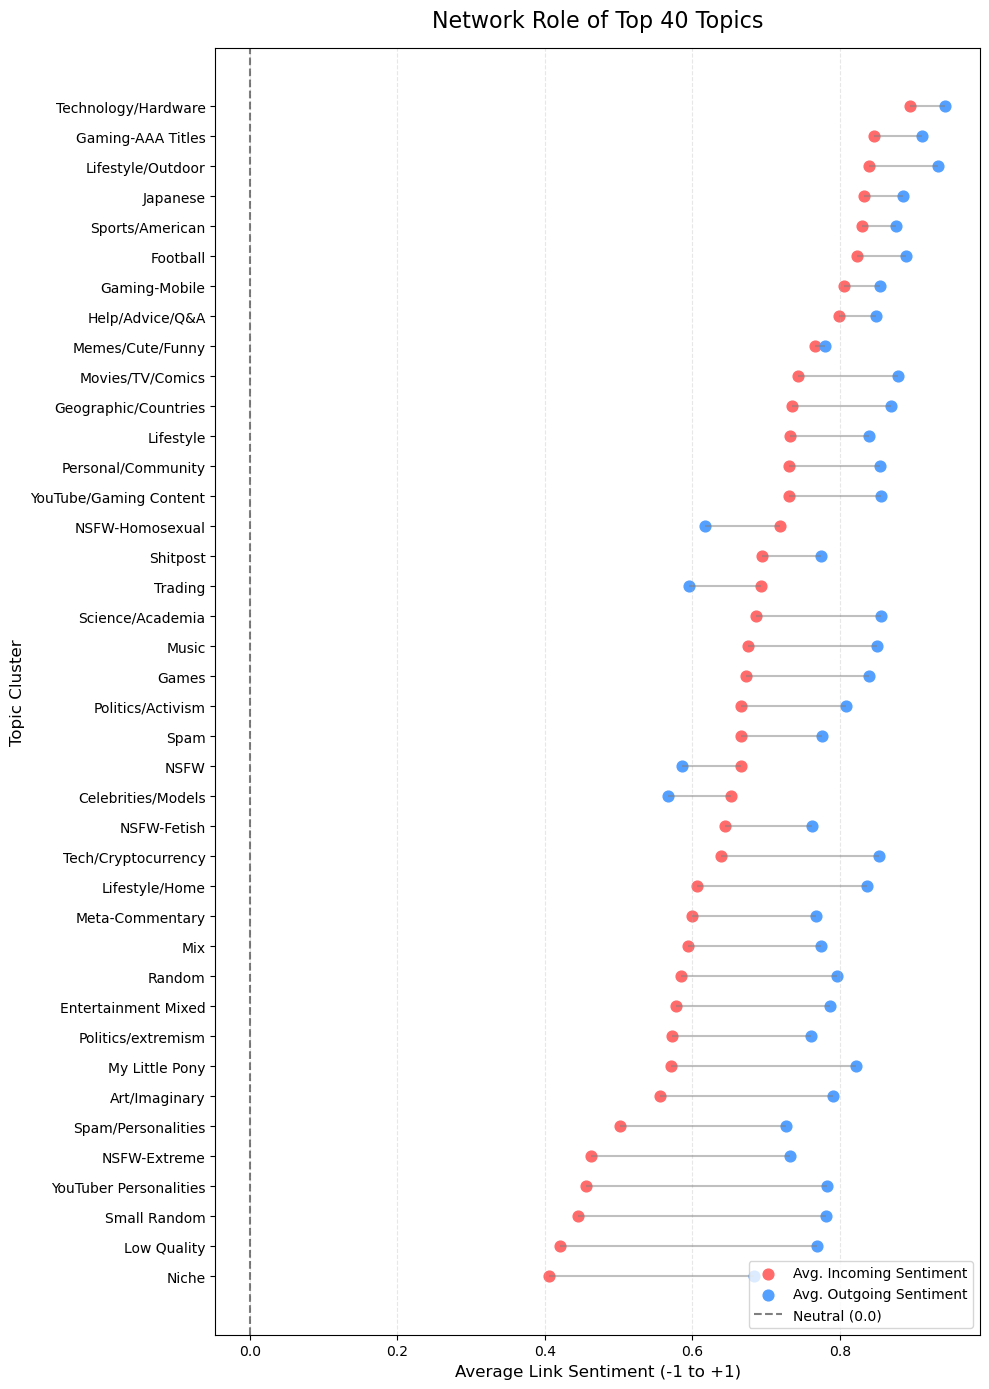

Saved PNG: /home/hamza/barrADA/ada-2025-project-barrada/results/figures/step6_topic_network_role.png


KeyError: "'YlRdGn' is not a known colormap name"

<Figure size 1200x600 with 0 Axes>

In [ ]:
print("--- Loading All Final Datasets ---")
df_final = load_final_dataset()
df_hyperlinks = load_hyperlinks_data()
df_clusters = load_topic_clusters()   
df_cluster_labels = load_cluster_labels()

# --- Generate Static PNGs ---
print("\n--- Generating 5 Static PNGs (will display below) ---")

if df_final is not None:
    plot_topic_network_role(df_final)
    plot_liwc_role_lift(df_final,role_columns=["role_controversial","role_influential"])
    plot_liwc_role_lift(df_final,role_columns=["role_critical","role_supportive"])
    plot_semantic_structural_heatmap(df_final)
else:
    print("Skipping PNG plots: 'final_dataset.csv' not found.")

print("\nSTEP 6 FINAL VISUALIZATION COMPLETE")
print(f"PNGs saved to: {FIGURES_DIR}")